## Perosnal Finance: Analysis

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

In [66]:
finance_data = pd.read_csv('dataset/personal_finance_kestrl.csv')
finance_data.sample(3)

,bank_id,category_id,amount,merchant_name,ob_transaction_type,ob_transaction_category,ob_transaction_timestamp,category
1366,232,16,-9556,tesco petrol station,DEBIT,DEBIT,2022-06-17 10:53:32,Groceries
103,1288,11,-165,transport for london,DEBIT,PURCHASE,2022-03-03 14:59:50,Transportation
239,232,15,-1909,foyles stratford on 18 jun clp,DEBIT,DEBIT,2021-06-19 10:31:20,General


The personal finance data contains the following columns:

- bank_id: Identifier for the bank.
- category_id: Identifier for the category of transaction.
- amount: The amount of the transaction (negative for expenses, positive for income).
- merchant_name: Name of the merchant involved in the transaction.
- ob_transaction_type: Type of the transaction, like DEBIT or CREDIT.
- ob_transaction_category: Category of the transaction, such as PURCHASE or TRANSFER.
- ob_transaction_timestamp: Timestamp of the transaction.
- category: General category of the transaction (e.g., Groceries, Income, Shopping).

### Expenditure Analysis

#### Expenditure by Category
The first bar chart shows your total expenditure sorted by category. This provides an insight into which categories you spend the most in. Categories with the largest negative values represent higher spending.

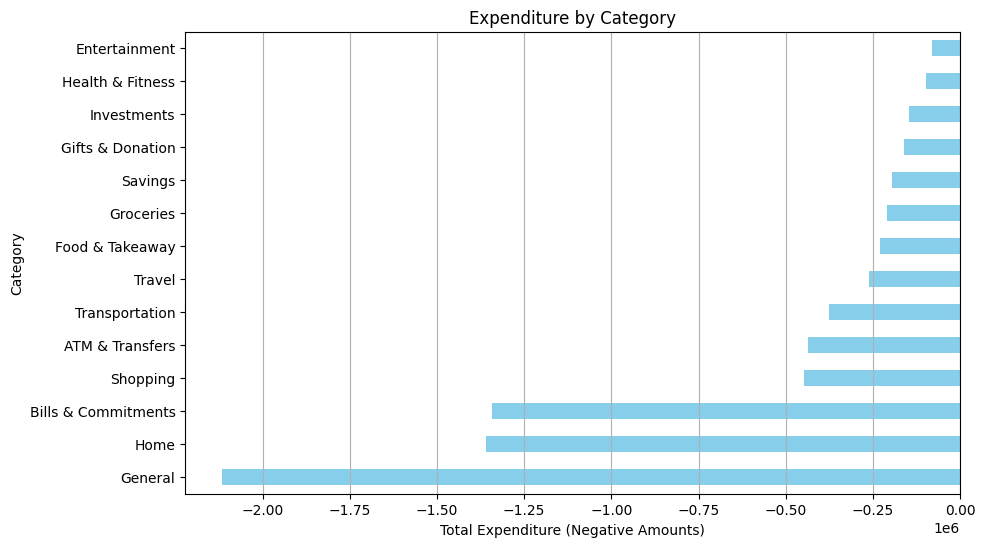

In [69]:
# Filter out income transactions for expenditure analysis
expenses = finance_data[finance_data['amount'] < 0]

# Expenditure by Category
expenditure_by_category = expenses.groupby('category')['amount'].sum().sort_values()

# Plotting Expenditure by Category
plt.figure(figsize=(10, 6))
expenditure_by_category.plot(kind='barh', color='skyblue')
plt.title('Expenditure by Category')
plt.xlabel('Total Expenditure (Negative Amounts)')
plt.ylabel('Category')
plt.grid(axis='x')
plt.show()

#### Expenditure by Merchant
The second bar chart displays the top 10 merchants where you spend the most. This can help identify specific merchants where your spending is concentrated.

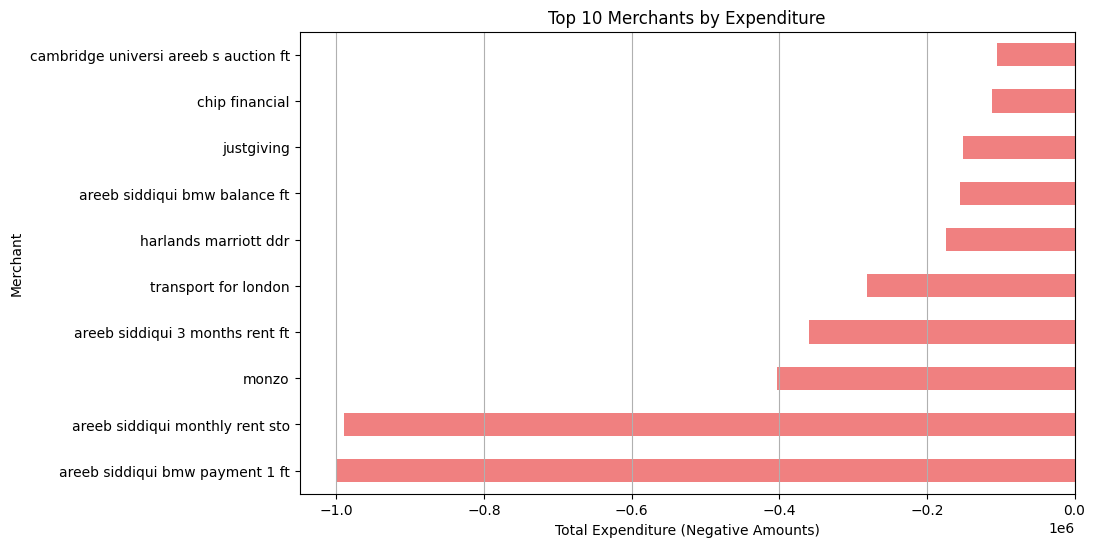

In [70]:
# Expenditure by Merchant
expenditure_by_merchant = expenses.groupby('merchant_name')['amount'].sum().sort_values()[:10]  # Top 10 merchants

# Plotting Expenditure by Merchant
plt.figure(figsize=(10, 6))
expenditure_by_merchant.plot(kind='barh', color='lightcoral')
plt.title('Top 10 Merchants by Expenditure')
plt.xlabel('Total Expenditure (Negative Amounts)')
plt.ylabel('Merchant')
plt.grid(axis='x')
plt.show()

#### Spending Trends Over Time
The line chart  illustrates  monthly spending trends. Each point represents the total expenditure for a given month. This visualization can help to see how spending fluctuates over time.

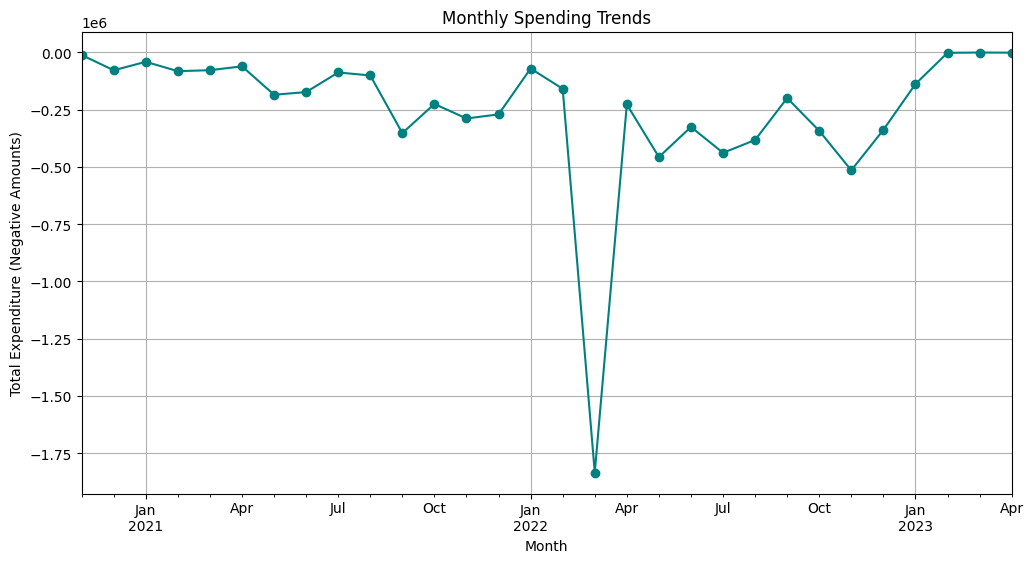

In [73]:
# Convert the transaction timestamp to datetime and extract year-month for trend analysis
expenses['transaction_date'] = pd.to_datetime(expenses['ob_transaction_timestamp']).dt.to_period('M')

# Spending Trends Over Time (Monthly)
monthly_expenditure_trend = expenses.groupby('transaction_date')['amount'].sum()

# Plotting Monthly Spending Trends
plt.figure(figsize=(12, 6))
monthly_expenditure_trend.plot(kind='line', marker='o', color='teal')
plt.title('Monthly Spending Trends')
plt.xlabel('Month')
plt.ylabel('Total Expenditure (Negative Amounts)')
plt.grid()
plt.show()


### Income Analysis

#### Income Sources
The bar chart  shows  top 10 income sources, based on the total income received from each source. This visualization helps in identifying the primary contributors to income.

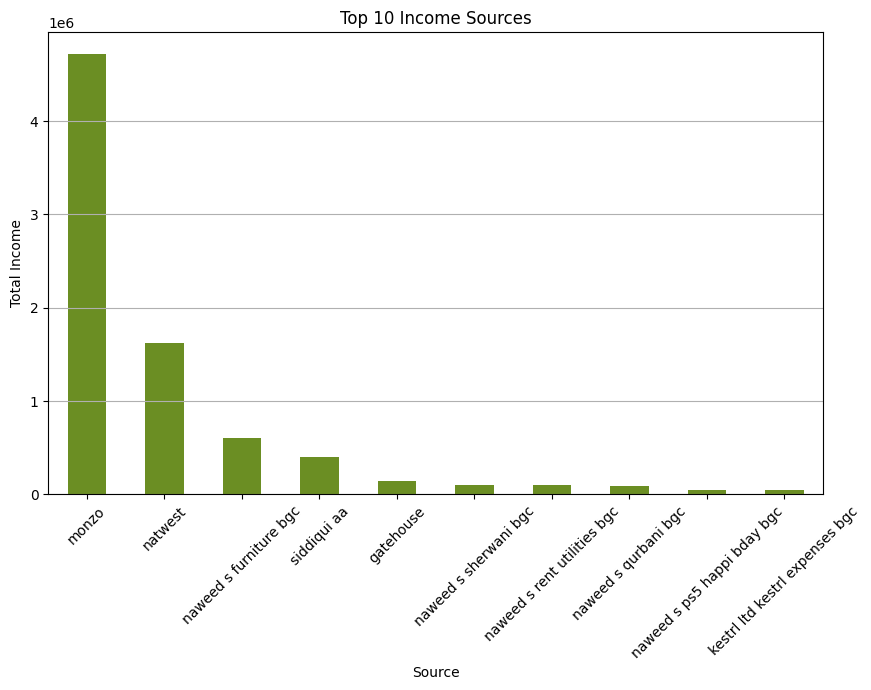

In [74]:
# Filter out expense transactions for income analysis
income = finance_data[finance_data['amount'] > 0]

# Income by Source (Merchant)
income_by_source = income.groupby('merchant_name')['amount'].sum().sort_values(ascending=False)[:10]  # Top 10 sources

# Plotting Income by Source
plt.figure(figsize=(10, 6))
income_by_source.plot(kind='bar', color='olivedrab')
plt.title('Top 10 Income Sources')
plt.xlabel('Source')
plt.ylabel('Total Income')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

#### Income Trends Over Time
The line chart above depicts the trends in income on a monthly basis. Each point represents the total income for a specific month, providing a clear view of how income has varied over time.

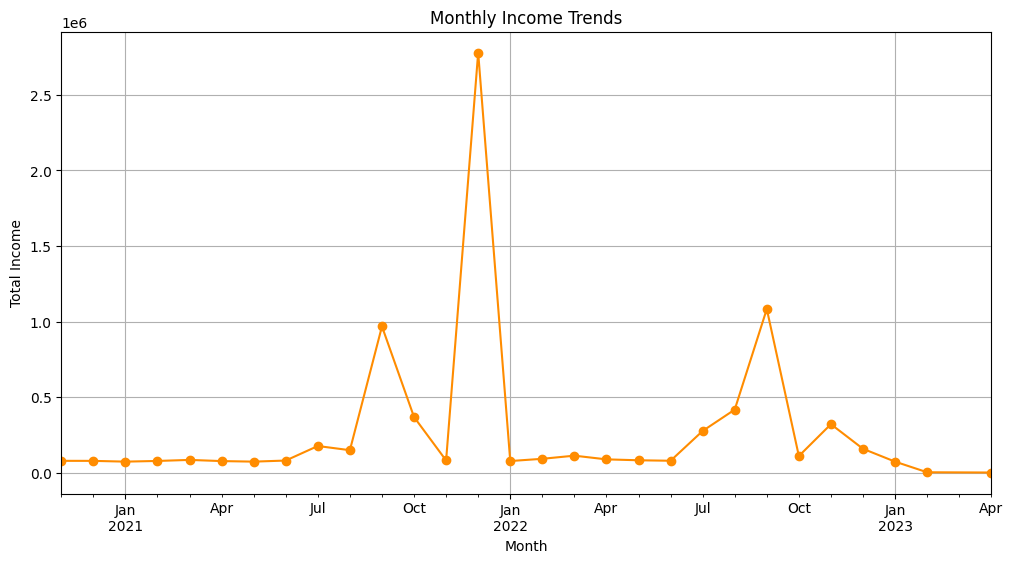

In [75]:
# Extract year-month for income trend analysis
income['transaction_date'] = pd.to_datetime(income['ob_transaction_timestamp']).dt.to_period('M')

# Income Trends Over Time (Monthly)
monthly_income_trend = income.groupby('transaction_date')['amount'].sum()

# Plotting Monthly Income Trends
plt.figure(figsize=(12, 6))
monthly_income_trend.plot(kind='line', marker='o', color='darkorange')
plt.title('Monthly Income Trends')
plt.xlabel('Month')
plt.ylabel('Total Income')
plt.grid()
plt.show()

### Cash Flow Analysis
The bar chart  presents a monthly comparison of your total income (in orange) and expenses (in blue). The green line represents the net cash flow for each month, calculated as the difference between total income and total expenses.

<Figure size 1200x600 with 0 Axes>

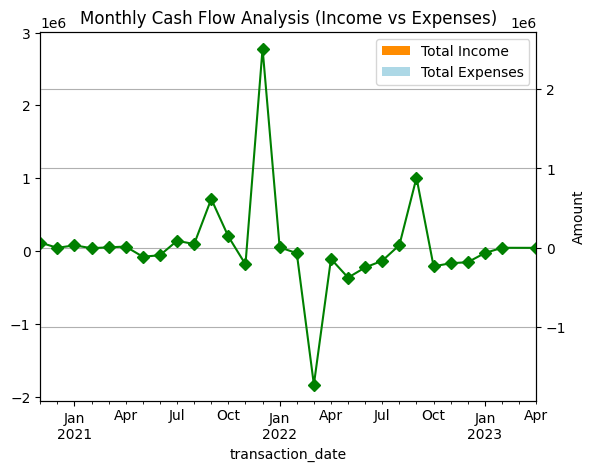

In [76]:
# Monthly Cash Flow Analysis (Income vs Expenses)
monthly_cash_flow = pd.concat([monthly_income_trend, monthly_expenditure_trend], axis=1)
monthly_cash_flow.columns = ['Total Income', 'Total Expenses']
monthly_cash_flow['Net Cash Flow'] = monthly_cash_flow['Total Income'] + monthly_cash_flow['Total Expenses']

# Plotting Monthly Cash Flow
plt.figure(figsize=(12, 6))
monthly_cash_flow[['Total Income', 'Total Expenses']].plot(kind='bar', stacked=True, color=['darkorange', 'lightblue'])
monthly_cash_flow['Net Cash Flow'].plot(marker='D', color='green', secondary_y=True)
plt.title('Monthly Cash Flow Analysis (Income vs Expenses)')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.grid(axis='y')
plt.show()

### Deep dive into budgeting

#### Identify Recurring Expenses
The table above lists the top 10 recurring merchants in your expenses. These are merchants with transactions in at least 3 different months. The columns represent:

- min: Minimum number of transactions in a month.
- max: Maximum number of transactions in a month.
- mean: Average number of transactions per month.
- count: Total number of months with transactions.

In [77]:
# Identify recurring expenses
recurring_expenses = expenses.groupby(['merchant_name', expenses['transaction_date'].dt.month])['amount'].count().reset_index()
recurring_expenses = recurring_expenses.groupby('merchant_name')['amount'].agg(['min', 'max', 'mean', 'count'])

# Consider a merchant as recurring if transactions occur in at least 3 different months
recurring_merchants = recurring_expenses[recurring_expenses['count'] >= 3].sort_values(by='count', ascending=False)

recurring_merchants.head(10)  # Display top 10 recurring merchants

,min,max,mean,count
merchant_name,,,,
marks & spencer,1,7,2.750000,12
tesco,1,11,3.500000,12
apple,1,7,3.583333,12
audible uk,1,2,1.916667,12
vodafone,1,2,1.666667,12
boots,1,16,5.083333,12
transport for london,15,42,26.916667,12
pret a manger,2,18,8.916667,12
the minted app,1,3,2.000000,12


#### Analyze High Spending Months
The following are the top 5 months with the highest spending:
The negative values indicate the total expenditure for each month. March 2022 stands out with significantly higher expenses.

<AxesSubplot:xlabel='transaction_date'>

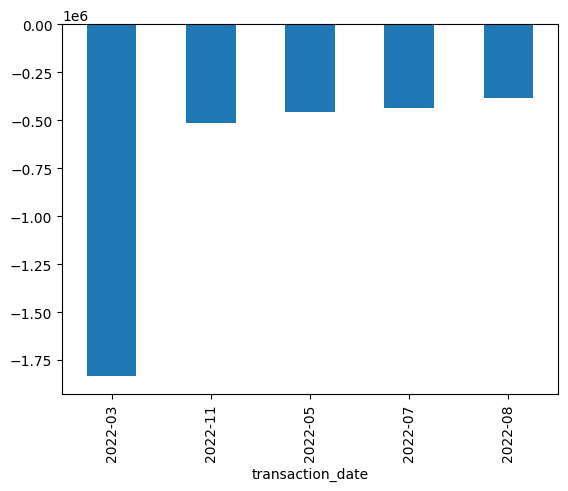

In [82]:
# Analyze high spending months
high_spending_months = expenses.groupby('transaction_date')['amount'].sum().sort_values()

# Identify top 5 months with highest spending
top_high_spending_months = high_spending_months.head(5)

top_high_spending_months
top_high_spending_months.plot.bar()

#### Assess Spending on Non-Essential Categories
The total spending on non-essential categories (like Entertainment, Shopping, Travel, Dining Out) is -786,977. This constitutes approximately 10.55% of  total expenditure. It's important to note that the classification of non-essential categories can be subjective and might vary based on personal preferences.

In [85]:
# Define non-essential categories (this may vary based on personal opinion)
non_essential_categories = ['Entertainment', 'Shopping', 'Travel', 'Dining Out']

# Filter and calculate spending on non-essential categories
non_essential_expenses = expenses[expenses['category'].isin(non_essential_categories)]
total_non_essential_spending = non_essential_expenses['amount'].sum()

# Calculate total spending
total_spending = expenses['amount'].sum()

# Calculate the proportion of non-essential spending
proportion_non_essential = total_non_essential_spending / total_spending

total_non_essential_spending, proportion_non_essential

(-786977, 0.10553424619324703)

#### Savings Rate Calculation
- Total Savings: 660,664
- Savings Rate: Approximately 8.14% of your income is being saved.

In [86]:
# Total income calculation
total_income = income['amount'].sum()

# Savings calculation (assuming savings = income - expenses)
total_savings = total_income + total_spending  # total_spending is negative

# Savings rate calculation (savings as a percentage of income)
savings_rate = total_savings / total_income

total_savings, savings_rate


(660664, 0.0813852031002221)

#### Budget Allocation Review
According to the 50/30/20 budgeting rule, here's how your budget allocation stands:

- Proportion Spent on Needs: Approximately -7.19% of your income.
- Proportion Spent on Wants: Approximately -9.69% of your income.
- Savings Rate: Approximately 8.14% of your income.

In [87]:
# Define categories for 'needs', 'wants', and 'savings' according to the 50/30/20 rule
needs_categories = ['Bills', 'Groceries', 'Rent/Mortgage', 'Transportation', 'Healthcare']
wants_categories = ['Entertainment', 'Shopping', 'Travel', 'Dining Out']

# Calculate spending in each category
spending_needs = expenses[expenses['category'].isin(needs_categories)]['amount'].sum()
spending_wants = expenses[expenses['category'].isin(wants_categories)]['amount'].sum()

# Proportions according to the 50/30/20 rule
proportion_needs = spending_needs / total_income
proportion_wants = spending_wants / total_income
proportion_savings = savings_rate  # Already calculated

proportion_needs, proportion_wants, proportion_savings

(-0.07190855189885954, -0.09694532013278079, 0.0813852031002221)

### Cash Flow forcasting

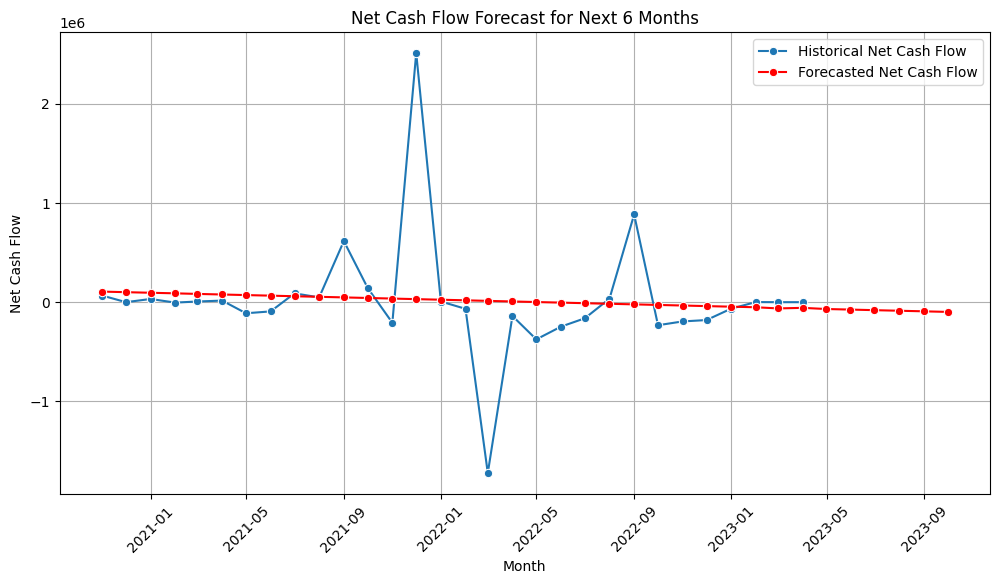

In [91]:
# Preparing data for forecasting
# We'll use the 'Net Cash Flow' column from our previous cash flow analysis
cash_flow_data = monthly_cash_flow['Net Cash Flow']
# Converting index to numeric for linear regression (number of months since start)
cash_flow_data_numeric_index = np.arange(len(cash_flow_data))

# Redefining X and X_forecast for the linear model
X = cash_flow_data_numeric_index.reshape(-1, 1)
X_forecast = np.arange(len(cash_flow_data) + 6).reshape(-1, 1)

# Check for NaN values in the cash flow data
nan_check = cash_flow_data.isna().sum()

# If NaN values exist, we'll fill them with a method suitable for time series (like forward fill)
if nan_check > 0:
    cash_flow_data_filled = cash_flow_data.fillna(method='ffill')
else:
    cash_flow_data_filled = cash_flow_data
lin_reg = LinearRegression()

# Refitting the linear regression model with filled data
lin_reg.fit(X, cash_flow_data_filled.values)

# Recreating the forecast
y_forecast_filled = lin_reg.predict(X_forecast)

# Plotting the forecast along with historical data
plt.figure(figsize=(12, 6))
sns.lineplot(x=cash_flow_data_filled.index, y=cash_flow_data_filled.values, label='Historical Net Cash Flow', marker='o')
sns.lineplot(x=cash_flow_data_filled.index.append(pd.date_range(start=cash_flow_data_filled.index[-1] + pd.DateOffset(months=1), 
                                                         periods=6, freq='M')), 
             y=y_forecast_filled, label='Forecasted Net Cash Flow', marker='o', color='red')
plt.title('Net Cash Flow Forecast for Next 6 Months')
plt.xlabel('Month')
plt.ylabel('Net Cash Flow')
plt.xticks(rotation=45)
plt.grid()
plt.show()
